# **AE3**

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder

# **Available activation functions**

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def linear(x):
    return x

def linear_derivative(x):
    return np.ones_like(x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - x**2

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

# **Single layer definition**

In [3]:
class Layer:
    
    def __init__(self, input_dim, output_dim, activation='sigmoid', weights_init='uniform'):
        """
        Initializes a single layer in the neural network.

        Parameters:
        - input_dim (int): Number of input neurons (features).
        - output_dim (int): Number of output neurons.
        - activation (str, optional): Activation function to use ('sigmoid' by default). 
          Supported: 'sigmoid', 'linear', 'relu', 'tanh', 'softmax'.
        - weights_init (str, optional): Weight initialization method ('uniform' by default).
          Available methods:
            - 'uniform' : Weights initialized from a uniform distribution.
            - 'normal'  : Weights initialized from a normal distribution.
            - 'xavier'  : Xavier/Glorot initialization (good for tanh).
            - 'he'      : He initialization (good for ReLU).

        Raises:
        - ValueError: If an unknown weight initialization method or activation function is provided.
        """
        
        weight_initializers = {
            'uniform': lambda: np.random.uniform(0, 1, size=(input_dim, output_dim)),
            'normal': lambda: np.random.randn(input_dim, output_dim),  
            'xavier': lambda: np.random.randn(input_dim, output_dim) * np.sqrt(2 / (input_dim + output_dim)),
            'he': lambda: np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim) 
        }

        if weights_init not in weight_initializers:
            raise ValueError(f"Unknown initialization method: {weights_init}. Available: {list(weight_initializers.keys())}")

        self.weights = weight_initializers[weights_init]()
        self.biases = np.zeros((1, output_dim))
        
        activation_functions = {
            'sigmoid' : sigmoid,
            'linear' : linear,
            'relu' : relu,
            'tanh' : tanh,
            'softmax' : softmax
        }
        
        activation_derivatives = {  
            'sigmoid': sigmoid_derivative,
            'linear': linear_derivative,
            'relu' : relu_derivative,
            'tanh' : tanh_derivative
        }

        self.activation = activation_functions.get(activation)
        self.activation_derivative = activation_derivatives.get(activation)
        
        if self.activation is None:
            raise ValueError(f"Unknown activation function: {activation}. Available: {list(activation_functions.keys())}")

        
    def forward(self, X):
        """
        Performs forward propagation through the layer.

        Parameters:
        - X (numpy array): Input data (shape: number of samples × input features).

        Returns:
        - numpy array: Activated output of the layer.
        """
        return self.activation(np.dot(X, self.weights) + self.biases)


# **MLP with genetic algorithm**

In [ ]:
class MLP:
    
    def __init__(self, layers, weights_init='uniform', classification=False):
        """
        Initializes the multi-layer perceptron (MLP).
        
        Parameters:
        - layers (list of dicts): Each dictionary defines a Layer object with keys:
            - 'input_dim' (int): Number of input neurons.
            - 'output_dim' (int): Number of output neurons.
            - 'activation' (str): Activation function name.
        - weights_init (str, optional): Method for weight initialization ('uniform' by default).
        """
        self.layers = [Layer(layer['input_dim'], layer['output_dim'], layer['activation'], weights_init) for layer in layers]
        self.classification = classification
        self.weights_history = []

    def feedforward(self, X):
        """
        Performs forward propagation through the network.
        
        Parameters:
        - X (numpy array): Input data (shape: number of samples × input features).

        Returns:
        - activations (list of numpy arrays): Activations of each layer including input and output.
        """
        activations = [X]
        for i, layer in enumerate(self.layers):
            activations.append(layer.forward(activations[i]))
        return activations

    def predict(self, X):
        """
        Computes the network's output for given input data.
        
        Parameters:
        - X (numpy array): Input data.

        Returns:
        - numpy array: The final network output (predicted values).
        """
        if self.classification:
            preds = np.array(self.feedforward(X)[-1])
            return np.argmax(preds, axis=1).flatten()
        return np.array(self.feedforward(X)[-1]).reshape(-1,)

    def train(self, 
        X_train, 
        y_train, 
        epochs=500, 
        learning_rate=0.1, 
        batch_size=None,
        optimizer=None, 
        beta=0.9,  
        epsilon=1e-8,
        regularization=None,
        lambda_reg=0.01,
        X_val=None,
        y_val=None,
        early_stopping=False,
        patience=10 
        ):
        """
        Trains the neural network using mini-batch gradient descent and backpropagation.
        Includes optional support for optimizers, regularization, and early stopping.
        
        Parameters:
        - X_train (numpy array): Training input data.
        - y_train (numpy array): Training target values.
        - epochs (int, optional): Number of training iterations (default is 500).
        - learning_rate (float, optional): Step size for weight updates (default is 0.1).
        - batch_size (int, optional): Number of samples per batch. If None, full-batch is used.
        - optimizer (str, optional): 'momentum' or 'rmsprop' to apply these optimizers. Default is None.
        - beta (float, optional): Momentum and RMSProp smoothing constant. Default is 0.9.
        - epsilon (float, optional): Small constant for numerical stability in RMSProp. Default is 1e-8.
        - regularization (str, optional): 'l1', 'l2', or None for no regularization.
        - lambda_reg (float, optional): Regularization coefficient. Default is 0.01.
        - X_val (numpy array, optional): Validation input data for early stopping.
        - y_val (numpy array, optional): Validation target values for early stopping.
        - early_stopping (bool, optional): Enables early stopping if True. Default is False.
        - patience (int, optional): Number of epochs without improvement to wait before stopping. Default is 10.
        
        Returns:
        - None (prints training progress and plots weight evolution).
        """
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        loss = []
        self.weights_history = []

        if batch_size is None:
            batch_size = len(X_train)
            
        if self.classification:
            y_train_oh = self.one_hot_encode(y_train)
            
        if self.classification and y_val is not None:
            y_val_oh = self.one_hot_encode(y_val)

        if optimizer == 'momentum':
            velocity_w = [np.zeros_like(layer.weights) for layer in self.layers]
            velocity_b = [np.zeros_like(layer.biases) for layer in self.layers]
        elif optimizer == 'rmsprop':
            caches_w = [np.zeros_like(layer.weights) for layer in self.layers]
            caches_b = [np.zeros_like(layer.biases) for layer in self.layers]
            
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_weights = None

        for epoch in range(epochs):
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)

            for i in range(0, len(X_train), batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices].reshape(-1, 1) if not self.classification else y_train_oh[batch_indices]

                weights_error = [np.zeros_like(layer.weights) for layer in self.layers]
                biases_error = [np.zeros_like(layer.biases) for layer in self.layers]

                activations = self.feedforward(X_batch)

                weights_error, biases_error = self.backpropagate(activations, y_batch)

                for j, layer in enumerate(self.layers):
                    reg_grad = self.regularization(weights_error[j], layer.weights, regularization, lambda_reg)

                    if optimizer == 'momentum':
                        velocity_w[j] = beta * velocity_w[j] + learning_rate * reg_grad
                        layer.weights -= velocity_w[j]
                        velocity_b[j] = beta * velocity_b[j] + learning_rate * biases_error[j]
                        layer.biases -= velocity_b[j]
                    elif optimizer == 'rmsprop':
                        caches_w[j] = beta * caches_w[j] + (1 - beta) * np.square(reg_grad)
                        layer.weights -= learning_rate * reg_grad / (np.sqrt(caches_w[j]) + epsilon)
                        caches_b[j] = beta * caches_b[j] + (1 - beta) * np.square(biases_error[j])
                        layer.biases -= learning_rate * biases_error[j] / (np.sqrt(caches_b[j]) + epsilon)
                    else:
                        layer.weights -= learning_rate * reg_grad
                        layer.biases -= learning_rate * biases_error[j]

            self.weights_history.append([layer.weights.copy() for layer in self.layers])

            if not self.classification:
                y_pred = self.predict(X_train)
                tmp_loss = self.mse(y_pred, y_train)   
                print(f"\nEpoch {epoch + 1}/{epochs}. Loss = {tmp_loss}.")
            else:
                y_pred_oh = self.feedforward(X_train)[-1]
                y_pred = np.argmax(y_pred_oh, axis=1).flatten() 
                tmp_loss = self.cross_entropy(y_train_oh, y_pred_oh)
                tmp_f1 = self.f1_score(y_train, y_pred)
                print(f"\nEpoch {epoch + 1}/{epochs}. Loss = {tmp_loss}. F1 Score = {tmp_f1}.")          
            if epoch >= 10:
                loss.append(tmp_loss)
            else:
                loss.append(None)
            
            if early_stopping and X_val is not None and y_val is not None:
                y_val_pred = self.feedforward(X_val)[-1]
                if self.classification:
                    val_loss = self.cross_entropy(y_val_oh, y_val_pred)
                else:
                    val_loss = self.mse(y_val, y_val_pred.reshape(-1,))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = [layer.weights.copy() for layer in self.layers]
                    best_biases = [layer.biases.copy() for layer in self.layers]
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= patience:
                    print(f"\nEarly stopping triggered after {epoch + 1} epochs. Best val loss: {best_val_loss:.10f}")
                    for i, layer in enumerate(self.layers):
                        layer.weights = best_weights[i]
                        layer.biases = best_biases[i]
                    break

        plt.figure(figsize=(14, 3))
        plt.plot(range(epoch + 1), loss, 'o')
        plt.title('Loss over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()
        #self.plot_weights_evolution()

    def backpropagate(self, activations, y_batch):
        """
        Performs backpropagation to compute gradients for weight and bias updates.

        Parameters:
        - activations (list of numpy arrays): Activations from feedforward pass.
        - y_batch (numpy array): Expected output.

        Returns:
        - Tuple (weight_gradients, bias_gradients) where:
            - weight_gradients (list of numpy arrays): Gradients for each layer’s weights.
            - bias_gradients (list of numpy arrays): Gradients for each layer’s biases.
        """
        
        batch_size = y_batch.shape[0]

        if self.classification:
            y_pred = activations[-1]  
        else:
            y_pred = activations[-1].reshape(-1, 1)
        
        if self.classification:
            deltas = [(y_pred - y_batch).reshape(-1, y_pred.shape[1])]
        else:
            error = (y_pred - y_batch).reshape(-1, 1)
            deltas = [error * self.layers[-1].activation_derivative(y_pred)]

        for i in range(len(self.layers) - 2, -1, -1):
            layer = self.layers[i]
            next_layer = self.layers[i + 1]
            
            error = deltas[-1] @ next_layer.weights.T  
            deltas.append(error * layer.activation_derivative(activations[i + 1]))

        deltas.reverse() 

        weight_gradients = [(activations[i].T @ deltas[i]) / batch_size for i in range(len(self.layers))]
        bias_gradients = [np.mean(deltas[i], axis=0, keepdims=True) for i in range(len(self.layers))]

        return weight_gradients, bias_gradients
    
    def regularization(self, gradient, weights, reg_type, reg_lambda):
        """
        Applies L1 or L2 regularization to a gradient during backpropagation.

        Parameters:
        - gradient (numpy array): The computed gradient before regularization.
        - weights (numpy array): Current weights of the layer.
        - reg_type (str): Regularization type ('l1', 'l2', or None).
        - reg_lambda (float): Regularization coefficient (lambda).

        Returns:
        - numpy array: Gradient modified with regularization term.
        """
        if reg_type == 'l2':
            return gradient + reg_lambda * weights
        elif reg_type == 'l1':
            return gradient + reg_lambda * np.sign(weights)
        return gradient    
   
    def plot_weights_evolution(self):
        """
        Plots the evolution of weights over epochs for each layer.

        Returns:
        - None (displays plots).
        """
        epochs = len(self.weights_history)
        for layer_idx in range(len(self.layers)):
            weights_per_epoch = np.array([epoch[layer_idx] for epoch in self.weights_history])  
            
            num_weights = weights_per_epoch[0].size  
            weights_per_epoch = weights_per_epoch.reshape(epochs, num_weights)

            plt.figure(figsize=(8, 5))
            for w in range(num_weights):
                plt.plot(range(epochs), weights_per_epoch[:, w], alpha=0.7)

            plt.title(f'Weight Evolution in Layer {layer_idx + 1}')
            plt.xlabel('Epoch')
            plt.ylabel('Weight Value')
            plt.legend()
            plt.show()       
            
    def one_hot_encode(self, y, num_classes=None):
        """
        Converts class labels to one-hot encoding.

        Parameters:
        - y (numpy array): Class labels.

        Returns:
        - numpy array: One-hot encoded labels.
        """
        if num_classes is None:
            num_classes = len(np.unique(y))
            
        y = y.flatten()
        y = y.astype(int)
        y_oh = np.zeros((len(y), num_classes))
        y_oh[np.arange(len(y)), y] = 1
        return y_oh            

    def set_weights_and_biases(self, layer_idx, W, b):
        """
        Sets custom weights and biases for a specific layer.

        Parameters:
        - layer_idx (int): Index of the layer (0-based).
        - W (numpy array): New weight matrix for the layer.
        - b (numpy array): New bias vector for the layer.

        Returns:
        - None
        """
        self.layers[layer_idx].weights = W
        self.layers[layer_idx].biases = b

    def mse(self, y_true, y_pred):
        """
        Computes the Mean Squared Error (MSE) loss.

        Parameters:
        - y_true (numpy array): True target values.
        - y_pred (numpy array): Predicted values from the network.

        Returns:
        - float: Computed MSE loss.
        """
        return np.mean((y_true - y_pred) ** 2)
    
    def f1_score(self, y_true, y_pred):
        """
        Computes the F1-score for multi-class classification using macro-averaging.
        
        :param y_true: List or array of true class labels
        :param y_pred: List or array of predicted class labels
        :return: Macro-averaged F1-score value
        """
        classes = set(y_true) | set(y_pred)
        total_f1 = 0
        
        for cls in classes:
            tp = sum((yt == cls and yp == cls) for yt, yp in zip(y_true, y_pred))
            fp = sum((yt != cls and yp == cls) for yt, yp in zip(y_true, y_pred))
            fn = sum((yt == cls and yp != cls) for yt, yp in zip(y_true, y_pred))
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            total_f1 += f1
        
        return total_f1 / len(classes) if classes else 0

    def cross_entropy(self, y_true, y_pred):
        """
        Computes the cross-entropy loss for multi-class classification.

        Parameters:
        - y_true (numpy array): True target values (one-hot encoded).
        - y_pred (numpy array): Predicted probabilities from the network.

        Returns:
        - float: Computed cross-entropy loss.
        """
        epsilon = 1e-15  
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    def get_weights_vector(self):
        """
        Flattens and concatenates all weights and biases from the network layers into a single vector.

        Returns:
        - numpy array: A 1D vector containing all flattened weights and biases.
        """
        vectors = []
        for layer in self.layers:
            vectors.append(layer.weights.flatten())
            vectors.append(layer.biases.flatten())
        return np.concatenate(vectors)

    def set_weights_vector(self, vector):
        """
        Sets the weights and biases of the network layers based on a flattened weight vector.

        Parameters:
        - vector (numpy array): A 1D vector containing all weights and biases to be reshaped 
                                and assigned to the corresponding layers.

        Returns:
        - None
        """
        idx = 0
        for layer in self.layers:
            w_size = layer.weights.size
            b_size = layer.biases.size
            layer.weights = vector[idx:idx + w_size].reshape(layer.weights.shape)
            idx += w_size
            layer.biases = vector[idx:idx + b_size].reshape(layer.biases.shape)
            idx += b_size

    def evaluate_fitness(self, weights_vector, X_train, y_train):
        """
        Sets the network weights and calculates the fitness error.

        For classification tasks, returns cross-entropy loss.
        For regression tasks, returns mean squared error (MSE).

        Parameters:
        - weights_vector (numpy array): Flattened vector of network weights and biases.
        - X_train (numpy array): Input training data.
        - y_train (numpy array): True training labels or targets.

        Returns:
        - float: Computed fitness value (cross-entropy or MSE).
        """
        self.set_weights_vector(weights_vector)
        y_pred = self.feedforward(X_train)[-1]
        if self.classification:
            y_train_oh = self.one_hot_encode(y_train)
            loss = self.cross_entropy(y_train_oh, y_pred)
        else:
            y_pred = y_pred.reshape(-1,)
            loss = self.mse(y_train, y_pred)
        return loss

    def train_genetic(self, X_train, y_train, 
                    population_size=50,
                    generations=100,
                    mutation_rate=0.1,
                    crossover_rate=0.7,
                    elite_size=0.1,
                    initial_weights_vector=None,  
                    noise_std=0.01): 
        """
        Trains the MLP using a genetic algorithm.

        Parameters:
        - X_train (numpy array): Training input data.
        - y_train (numpy array): Training target labels.
        - population_size (int): Number of individuals in the population.
        - generations (int): Number of generations to run the algorithm.
        - mutation_rate (float): Probability of mutating a single gene.
        - crossover_rate (float): Probability of crossover between individuals.
        - elite_size (float): Fraction of top individuals passed unchanged to the next generation.
        - initial_weights_vector (numpy array or None): Optional initial weights vector to seed the population.
        - noise_std (float): Standard deviation of noise added to initial weights when seeding.

        Returns:
        - None
        """
        vector_length = len(self.get_weights_vector())

        if initial_weights_vector is not None:
            population = [initial_weights_vector + np.random.normal(0, noise_std, vector_length) 
                        for _ in range(population_size)]
        else:
            population = [np.random.uniform(0, 1, size=vector_length) 
                        for _ in range(population_size)]

        best_loss_history = []
        best_weights = None
        best_loss = float('inf')

        for gen in range(generations):
            fitness_scores = np.array([self.evaluate_fitness(ind, X_train, y_train) for ind in population])

            sorted_idx = np.argsort(fitness_scores)
            population = [population[i] for i in sorted_idx]
            fitness_scores = fitness_scores[sorted_idx]

            new_population = population[:int(elite_size*population_size)]

            if fitness_scores[0] < best_loss:
                best_loss = fitness_scores[0]
                best_weights = population[0].copy()

            while len(new_population) < population_size:
                parents = np.random.choice(population_size, 2, replace=False, p=None)
                parent1 = population[parents[0]]
                parent2 = population[parents[1]]

                if np.random.rand() < crossover_rate:
                    crossover_point = np.random.randint(1, vector_length-1)
                    child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
                    child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
                else:
                    child1, child2 = parent1.copy(), parent2.copy()

                child1 = self.mutate(child1, mutation_rate)
                child2 = self.mutate(child2, mutation_rate)

                new_population.append(child1)
                new_population.append(child2)

            population = new_population

            print(f"Generation {gen+1}/{generations}, Best Fitness: {-best_loss:.6f}")
            best_loss_history.append(best_loss)

        self.set_weights_vector(best_weights)

        plt.plot(range(1, generations+1), best_loss_history)
        plt.xlabel("Generation")
        plt.ylabel("Best Loss")
        plt.title("Genetic Algorithm Training Loss")
        plt.show()


    def mutate(self, individual, mutation_rate):
        """
        Mutates an individual by randomly altering its genes.

        Parameters:
        - individual (np.array): Weight vector representing the individual.
        - mutation_rate (float): Probability of mutating each gene.

        Returns:
        - np.array: The mutated individual.
        """
        for i in range(len(individual)):
            if np.random.rand() < mutation_rate:
                individual[i] += np.random.normal(0, 0.1)
        return individual

### **multimodal-large dataset**

Generation 1/100000, Best Fitness: -5033.233496
Generation 2/100000, Best Fitness: -5029.104168
Generation 3/100000, Best Fitness: -5028.580505
Generation 4/100000, Best Fitness: -5010.906698
Generation 5/100000, Best Fitness: -5010.906698
Generation 6/100000, Best Fitness: -5010.906698
Generation 7/100000, Best Fitness: -5010.906698
Generation 8/100000, Best Fitness: -5010.906698
Generation 9/100000, Best Fitness: -5010.906698
Generation 10/100000, Best Fitness: -5010.906698
Generation 11/100000, Best Fitness: -5010.906698
Generation 12/100000, Best Fitness: -5010.906698
Generation 13/100000, Best Fitness: -5010.906698
Generation 14/100000, Best Fitness: -5008.953477
Generation 15/100000, Best Fitness: -5003.215365
Generation 16/100000, Best Fitness: -5001.454602
Generation 17/100000, Best Fitness: -5001.454602
Generation 18/100000, Best Fitness: -4995.324736
Generation 19/100000, Best Fitness: -4994.339190
Generation 20/100000, Best Fitness: -4994.339190
Generation 21/100000, Best Fi

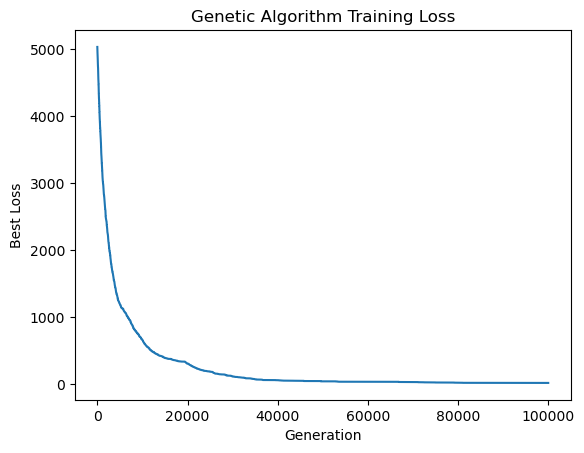

TRAIN MSE = 15.887511712140466
TEST MSE = 13.853372406788957


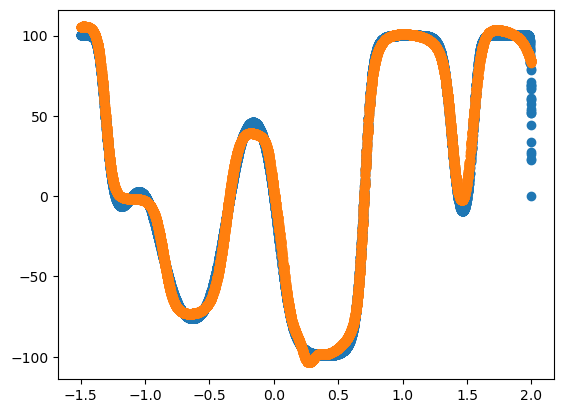

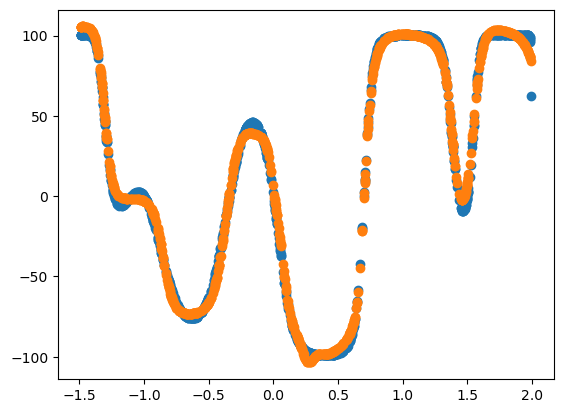

In [ ]:
multimodal_large_train = pd.read_csv('./data/multimodal-large-training.csv')
X_train_multimodal = np.array(multimodal_large_train['x']).reshape(-1, 1)
y_train_multimodal = np.array(multimodal_large_train['y'])

multimodal_large_test = pd.read_csv('./data/multimodal-large-test.csv')
X_test_multimodal = np.array(multimodal_large_test['x']).reshape(-1, 1)
y_test_multimodal = np.array(multimodal_large_test['y'])

mlp = MLP(layers=[
    {'input_dim' : 1, 'output_dim' : 29, 'activation' : 'tanh'},
    {'input_dim' : 29, 'output_dim' : 1, 'activation' : 'linear'}
])

mlp.train_genetic(X_train_multimodal, 
                  y_train_multimodal, 
                  generations=100000, 
                  population_size=3,
                  mutation_rate=0.1,
                  crossover_rate=0.9,
                  elite_size=0.3)

y_train_pred = mlp.predict(X_train_multimodal)
plt.figure()
plt.plot(X_train_multimodal, y_train_multimodal, 'o')
plt.plot(X_train_multimodal, y_train_pred, 'o')
plt.show
print(f"TRAIN MSE = {mlp.mse(y_train_pred, y_train_multimodal)}")

y_test_pred = mlp.predict(X_test_multimodal)
plt.figure()
plt.plot(X_test_multimodal, y_test_multimodal, 'o')
plt.plot(X_test_multimodal, y_test_pred, 'o')
plt.show
print(f"TEST MSE = {mlp.mse(y_test_pred, y_test_multimodal)}")

### **auto-mpg dataset**

Generation 1/30000, Best Fitness: -220.268041
Generation 2/30000, Best Fitness: -185.699230
Generation 3/30000, Best Fitness: -185.699230
Generation 4/30000, Best Fitness: -185.699230
Generation 5/30000, Best Fitness: -138.875980
Generation 6/30000, Best Fitness: -138.875980
Generation 7/30000, Best Fitness: -138.875980
Generation 8/30000, Best Fitness: -133.031982
Generation 9/30000, Best Fitness: -133.031982
Generation 10/30000, Best Fitness: -133.031982
Generation 11/30000, Best Fitness: -133.031982
Generation 12/30000, Best Fitness: -133.031982
Generation 13/30000, Best Fitness: -133.031982
Generation 14/30000, Best Fitness: -133.031982
Generation 15/30000, Best Fitness: -133.031982
Generation 16/30000, Best Fitness: -133.031982
Generation 17/30000, Best Fitness: -133.031982
Generation 18/30000, Best Fitness: -107.936356
Generation 19/30000, Best Fitness: -107.936356
Generation 20/30000, Best Fitness: -107.936356
Generation 21/30000, Best Fitness: -107.936356
Generation 22/30000, B

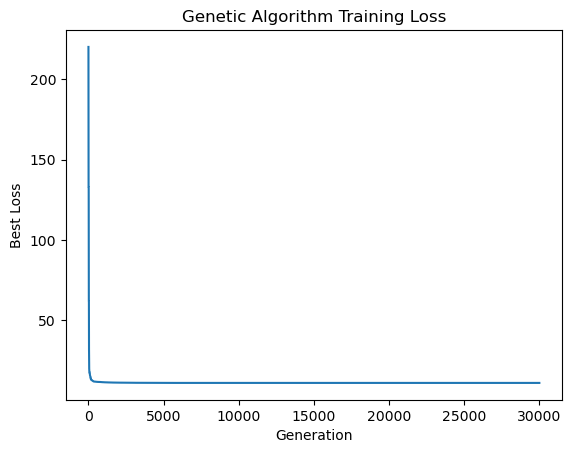

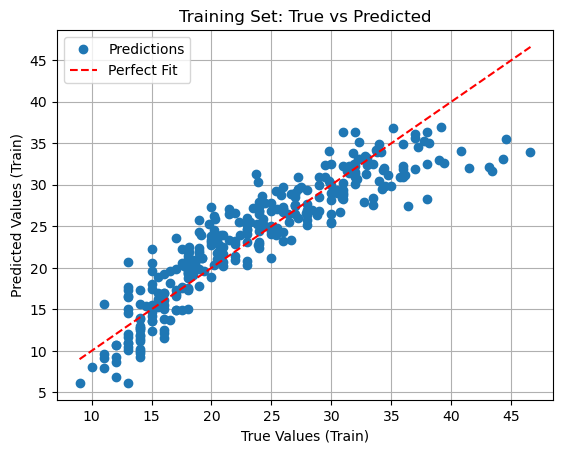

TRAIN MSE = 10.980144566659472


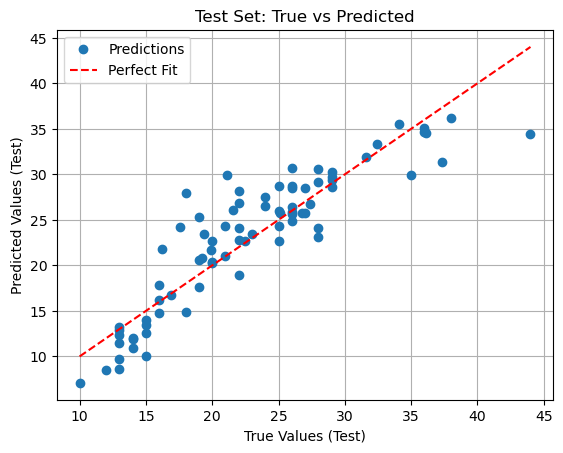

TEST MSE = 10.737341734461674


In [25]:
auto_mpg = fetch_ucirepo(id=9) 
  
features = auto_mpg.data.features
targets = auto_mpg.data.targets

data = pd.concat([features, targets], axis=1)
data = data.dropna()
X_auto = data[features.columns]
y_auto = data[targets.columns]

X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(X_auto, y_auto, test_size=0.2, random_state=42)

X_train_auto = np.array(X_train_auto)
y_train_auto = np.array(y_train_auto).reshape(-1,)
X_test_auto = np.array(X_test_auto)
y_test_auto = np.array(y_test_auto).reshape(-1,)

mlp = MLP(layers=[
    {'input_dim' : 7, 'output_dim' : 1, 'activation' : 'relu'},
    {'input_dim' : 1, 'output_dim' : 1, 'activation' : 'linear'}
])

mlp.train_genetic(X_train_auto, 
                  y_train_auto, 
                  generations=30000, 
                  population_size=300,
                  mutation_rate=0.1,
                  crossover_rate=0.9,
                  elite_size=0.3)

y_train_pred = mlp.predict(X_train_auto)
plt.figure()
plt.plot(y_train_auto, y_train_pred, 'o', label='Predictions')
plt.plot([min(y_train_auto), max(y_train_auto)],
         [min(y_train_auto), max(y_train_auto)],
         'r--', label='Perfect Fit')
plt.xlabel("True Values (Train)")
plt.ylabel("Predicted Values (Train)")
plt.title("Training Set: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

print(f"TRAIN MSE = {mlp.mse(y_train_pred, y_train_auto)}")

y_test_pred = mlp.predict(X_test_auto)
plt.figure()
plt.plot(y_test_auto, y_test_pred, 'o', label='Predictions')
plt.plot([min(y_test_auto), max(y_test_auto)],
         [min(y_test_auto), max(y_test_auto)],
         'r--', label='Perfect Fit')
plt.xlabel("True Values (Test)")
plt.ylabel("Predicted Values (Test)")
plt.title("Test Set: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

print(f"TEST MSE = {mlp.mse(y_test_pred, y_test_auto)}")

### **iris dataset**

Generation 1/5000, Best Fitness: -1.038425
Generation 2/5000, Best Fitness: -0.969782
Generation 3/5000, Best Fitness: -0.969782
Generation 4/5000, Best Fitness: -0.969782
Generation 5/5000, Best Fitness: -0.969782
Generation 6/5000, Best Fitness: -0.969782
Generation 7/5000, Best Fitness: -0.969782
Generation 8/5000, Best Fitness: -0.969782
Generation 9/5000, Best Fitness: -0.941408
Generation 10/5000, Best Fitness: -0.941408
Generation 11/5000, Best Fitness: -0.927157
Generation 12/5000, Best Fitness: -0.927157
Generation 13/5000, Best Fitness: -0.823536
Generation 14/5000, Best Fitness: -0.823536
Generation 15/5000, Best Fitness: -0.823536
Generation 16/5000, Best Fitness: -0.823536
Generation 17/5000, Best Fitness: -0.823536
Generation 18/5000, Best Fitness: -0.823536
Generation 19/5000, Best Fitness: -0.818998
Generation 20/5000, Best Fitness: -0.818998
Generation 21/5000, Best Fitness: -0.782203
Generation 22/5000, Best Fitness: -0.771330
Generation 23/5000, Best Fitness: -0.7273

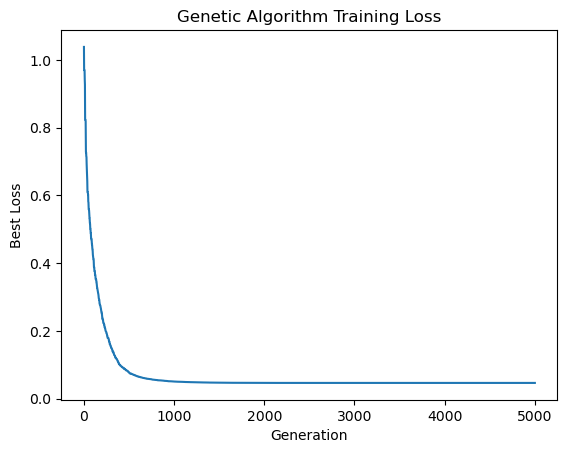

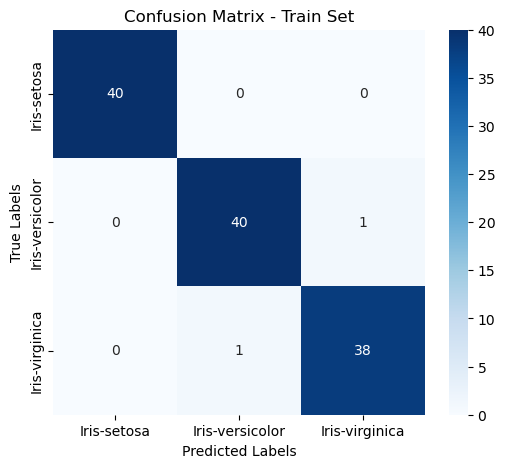

TRAIN F1-score = 0.9833


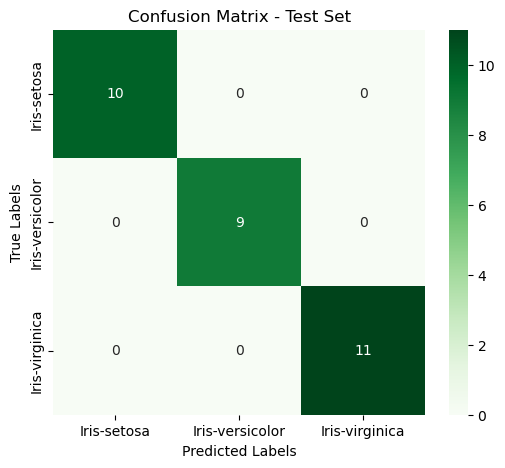

TEST F1-score = 1.0000


In [43]:
iris = fetch_ucirepo(id=53) 
  
features = iris.data.features
targets = iris.data.targets

data = pd.concat([features, targets], axis=1)
data = data.dropna()
X_iris = data[features.columns]
y_iris = data[targets.columns]

label_encoder = LabelEncoder()
y_iris = label_encoder.fit_transform(y_iris.values.ravel())

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)

X_train_iris = np.array(X_train_iris)
y_train_iris = np.array(y_train_iris).reshape(-1,)
X_test_iris = np.array(X_test_iris)
y_test_iris = np.array(y_test_iris).reshape(-1,)

mlp = MLP(layers=[
    {'input_dim' : 4, 'output_dim' : 1, 'activation' : 'relu'},
    {'input_dim' : 1, 'output_dim' : 3, 'activation' : 'softmax'}
],
          classification=True)

mlp.train_genetic(X_train_iris, 
                  y_train_iris, 
                  generations=5000, 
                  population_size=300,
                  mutation_rate=0.1,
                  crossover_rate=0.9,
                  elite_size=0.3)

y_train_pred = mlp.predict(X_train_iris)

cm_train = confusion_matrix(y_train_iris, y_train_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Train Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

f1_train = mlp.f1_score(y_train_iris, y_train_pred)
print(f"TRAIN F1-score = {f1_train:.4f}")

y_test_pred = mlp.predict(X_test_iris)

cm_test = confusion_matrix(y_test_iris, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

f1_test = mlp.f1_score(y_test_iris, y_test_pred)
print(f"TEST F1-score = {f1_test:.4f}")

As part of this project, a simple MLP network trained using a genetic algorithm was implemented. The training was conducted on three different datasets: Iris, Multimodal-large, and Auto-MPG.

The obtained results are very promising and demonstrate the high quality of the proposed solution. For the Multimodal-large dataset, the model achieved a mean squared error (MSE) of 15.88 on the training set and 13.86 on the test set. For the Auto-MPG dataset, the MSE values were 10.98 (training) and 10.74 (testing). The best performance was observed on the Iris dataset, with excellent F1-scores of 0.98 on the training set and a perfect 1.00 on the test set.

These results indicate the effectiveness and robustness of the approach and suggest that genetic algorithms can be a valuable alternative to the traditional backpropagation method for training neural networks.

No comparative tests or performance analyses were conducted, as they were beyond the scope of this task and due to hardware limitations and the lengthy computation times involved. Nonetheless, the experiments performed provide strong evidence that genetic algorithms represent a viable and efficient method for training neural networks.

